In [43]:
%load_ext autoreload
%autoreload 2

from gwak.train.dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten
from ml4gw.distributions import PowerLaw
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
#data_dir = "/n/netscratch/iaifi_lab/Lab/emoreno/O4_MDC_background/LV/"
data_dir = "/home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/HL/"
sample_rate = 4096
kernel_length = 1
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 512
batches_per_epoch = 50
num_workers = 2
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "CCSN",
    "Background", 
    "Glitch",
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None,
    None,
    None,
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None,
    None,
    None,
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None
]

In [45]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file,
    ifos="HL",
    snr_prior=PowerLaw(index=-3, minimum=4, maximum=30),                          
    glitch_root=f'/home/hongyin.chen/anti_gravity/gwak/gwak/output/omicron/HL/'
)
test_loader = loader.test_dataloader()

nevents = 10000

ifos are ['H1', 'L1']
data dir is /home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/HL/


/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:162: ContiguousHdf5Warning: /home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/HL/background-1403719267-11117.h5 stored contiguously – slower I/O
  warnings.warn(f"{fname} stored contiguously – slower I/O", ContiguousHdf5Warning)
/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:162: ContiguousHdf5Warning: /home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/HL/background-1403732248-8415.h5 stored contiguously – slower I/O
  warnings.warn(f"{fname} stored contiguously – slower I/O", ContiguousHdf5Warning)
/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:162: ContiguousHdf5Warning: /home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/HL/background-1403754093-2077.h5 stored contiguously – slower I/O
  warnings.warn(f"{fname} stored contiguously – slower I/

In [46]:
embed_model = torch.jit.load("/home/katya.govorkova/gwak2/gwak/output/ResNet_HL/model_JIT.pt")
embed_model.eval()
embed_model.to(device=device)

# Load metric model
metric_model = torch.jit.load("/home/katya.govorkova/gwak2/gwak/output/ResNet_HL_FM_multiSignalAndBkg/mlp_model_JIT.pt")
metric_model.eval()
metric_model.to(device=device)

RecursiveScriptModule(
  original_name=MLPModel
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc11): RecursiveScriptModule(original_name=Linear)
  (fc12): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (activation): RecursiveScriptModule(original_name=ReLU)
  (sigmaboy): RecursiveScriptModule(original_name=Sigmoid)
)

In [47]:
all_background_classes = ['Background', 'Glitch'] #, 'FakeGlitch']
all_classes = signal_classes
background_classes = [cls for cls in all_classes if cls in all_background_classes]
signal_classes = [cls for cls in all_classes if cls not in background_classes]
background_labels = [i+1 for i in range(len(all_classes)) if all_classes[i] in background_classes]
signal_labels = [i+1 for i in range(len(all_classes)) if all_classes[i] in signal_classes]
print('The signal classes are ', signal_classes)
print('The background classes are ', background_classes)
print('and the background labels are ', background_labels)

all_binary_labels = []
all_scores = []
all_embeddings = []
all_labels = []
all_context = []
all_snrs = []

n_iter = int(nevents/batch_size)
test_iter = iter(test_loader)
for i in tqdm(range(n_iter), desc="Processing batches"):
    clean_batch, glitch_batch = next(test_iter)
    clean_batch = clean_batch.to(device)
    glitch_batch = glitch_batch.to(device)

    processed, labels, snrs = loader.on_after_batch_transfer([clean_batch, glitch_batch], None,
        local_test=True)

    embeddings = embed_model(processed)

    scores = metric_model(embeddings).detach().cpu().numpy() 

    embeddings = embeddings.detach().cpu().numpy()

    labels = labels.detach().cpu().numpy()
    binary_labels = (~np.isin(labels, background_labels)).astype(int)


    all_binary_labels.append(binary_labels)
    all_labels.append(labels)
    all_scores.append(scores)
    all_embeddings.append(embeddings)
    all_snrs.append(snrs.detach().cpu().numpy())

    del clean_batch, glitch_batch, processed, embeddings, binary_labels, labels, scores, snrs
    torch.cuda.empty_cache()

all_binary_labels = np.concatenate(all_binary_labels, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_scores = np.concatenate(all_scores, axis=0)
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_snrs = np.concatenate(all_snrs, axis=0)

The signal classes are  ['SineGaussian', 'BBH', 'Gaussian', 'Cusp', 'Kink', 'KinkKink', 'WhiteNoiseBurst', 'CCSN']
The background classes are  ['Background', 'Glitch']
and the background labels are  [9, 10]


Processing batches: 100%|████████████████████████████████████████████████████████████████████████████| 19/19 [16:10<00:00, 51.09s/it]


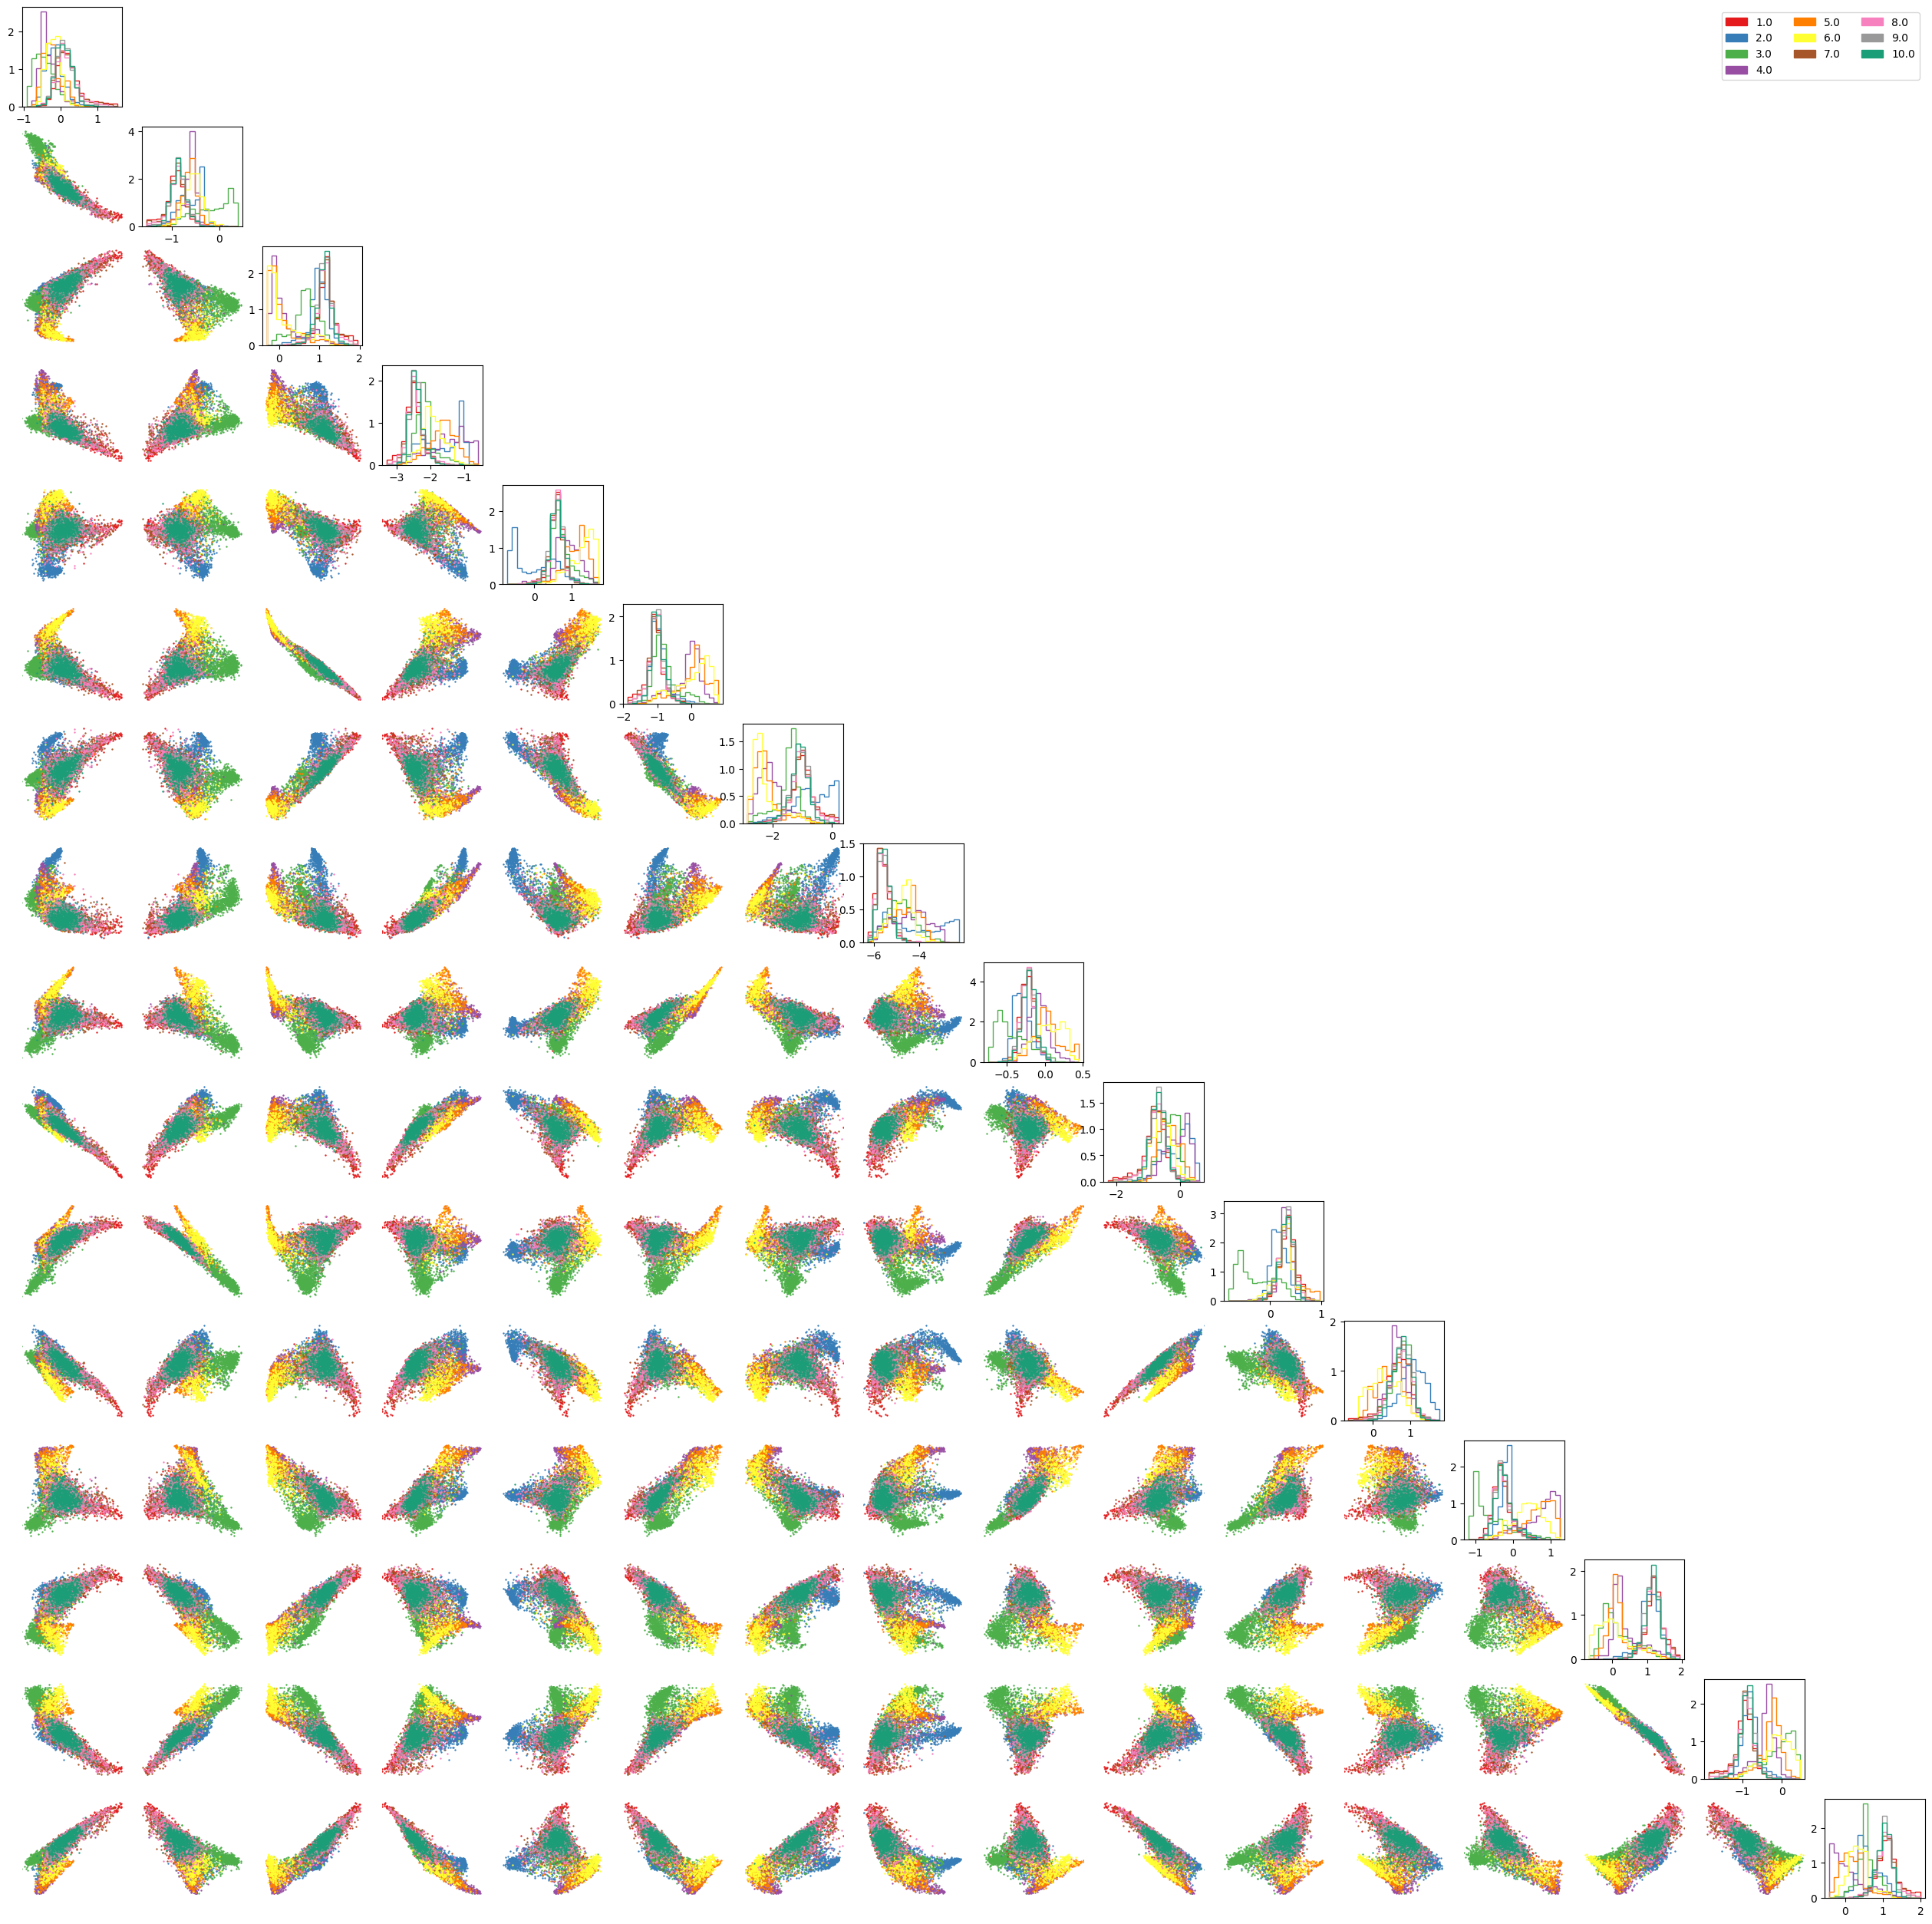

In [48]:
import sys
sys.path.append("../")
from plotting import make_corner
make_corner(all_embeddings, all_labels)

## use nf scores

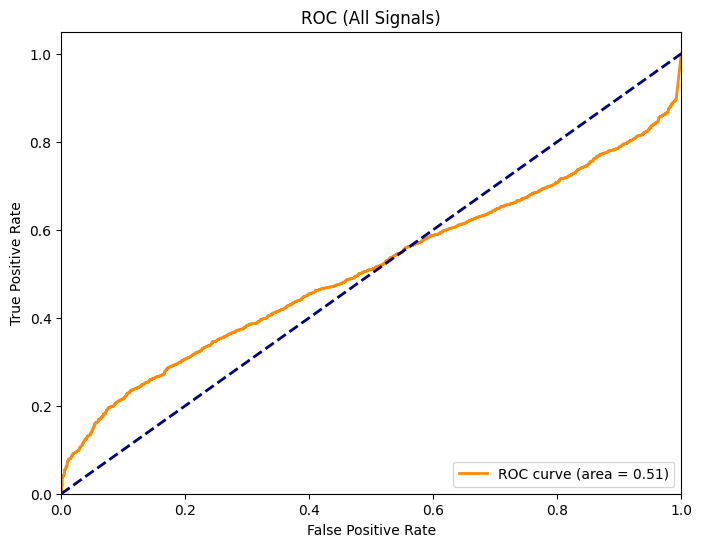

In [49]:
# Compute the ROC curve and AUC using scikit-learn
fpr, tpr, thresholds = roc_curve(all_binary_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (All Signals)")
plt.legend(loc="lower right")
plt.savefig("roc_combined.png")
plt.show()

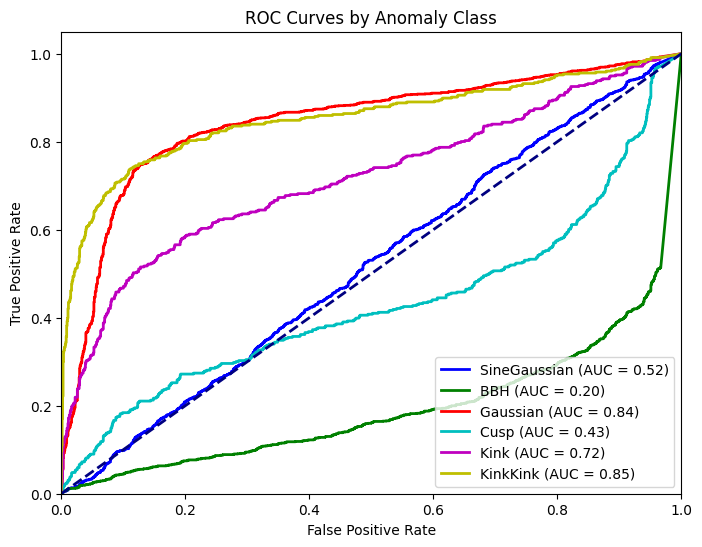

In [56]:
# Compute and plot ROC curves for each anomaly class (all but "Background").

plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for each anomaly class

for i, anomaly_class in enumerate(signal_classes[:-2]):  # Exclude "Background"
    # The anomaly class numeric label is i+1.
    anomaly_val = i + 1
    # Filter to only examples that are either the current anomaly class or Background (label 8).
    idx = np.where((all_labels == anomaly_val) | (all_labels == 8))[0]
    if idx.size == 0:
        continue  # skip if no examples
    scores_i = all_scores[idx]
    # Create binary ground truth: positive if the example is of the current anomaly class, 0 if background.
    binary_labels = (all_labels[idx] == anomaly_val).astype(int)
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(binary_labels, scores_i)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f"{anomaly_class} (AUC = {roc_auc:.2f})")

# Plot reference line (diagonal)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.yscale('log')
plt.title("ROC Curves by Anomaly Class")
plt.legend(loc="lower right")
plt.savefig("rocs_bySignal.png")
plt.show()

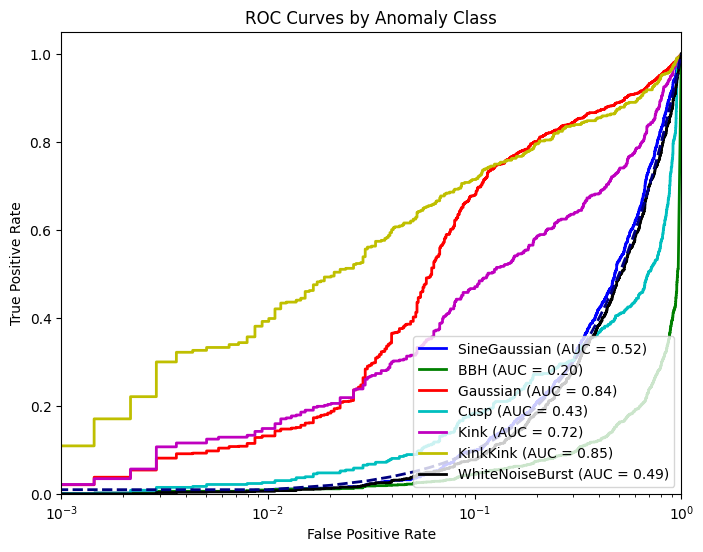

In [51]:
plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for each anomaly class

for i, anomaly_class in enumerate(signal_classes[:-1]):  # Exclude "Background"
    # The anomaly class numeric label is i+1.
    anomaly_val = i + 1
    # Filter to only examples that are either the current anomaly class or Background (label 8).
    idx = np.where((all_labels == anomaly_val) | (all_labels == 8))[0]
    if idx.size == 0:
        continue  # skip if no examples
    scores_i = all_scores[idx]
    # Create binary ground truth: positive if the example is of the current anomaly class, 0 if background.
    binary_labels = (all_labels[idx] == anomaly_val).astype(int)
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(binary_labels, scores_i)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f"{anomaly_class} (AUC = {roc_auc:.2f})")

# Plot reference line (diagonal)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), color="navy", lw=2, linestyle="--")
plt.xlim([1e-3, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#make x axis log
plt.xscale('log')

plt.title("ROC Curves by Anomaly Class")
plt.legend(loc="lower right")
plt.savefig("rocs_bySignal_logX.png")
plt.show()

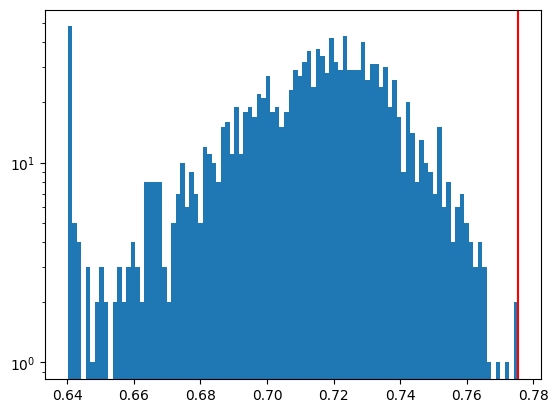

In [52]:
segment_duration = 0.5
year_sec = 3.154e7

fraction_1yr = (1.0 / year_sec) * segment_duration
# Extract background-only data
bg_mask = (all_labels == 8)
bg_scores = all_scores[bg_mask]
threshold_1yr = np.quantile(bg_scores,1-fraction_1yr)

h = plt.hist(bg_scores,bins=100)
plt.axvline(threshold_1yr,color='red')
plt.yscale('log')

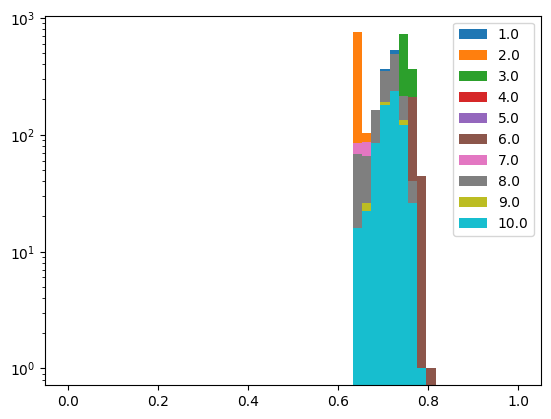

In [60]:
# Extract background-only data
for label in sorted(list(set(all_labels))):
    mask = (all_labels == label)
    h = plt.hist(all_scores[mask],bins=np.linspace(0,1,50),label=label)
    plt.yscale('log')
plt.legend()
#plt.xscale('log')

In [62]:
max(all_scores)

array([0.797369], dtype=float32)

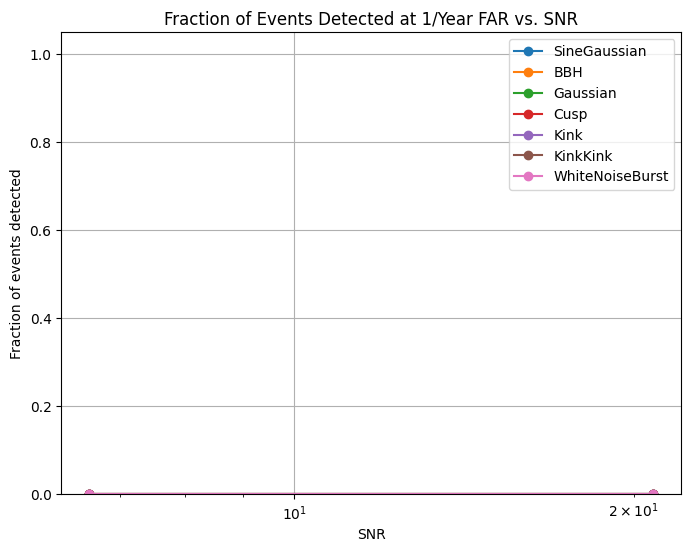

In [59]:
threshold_1yr = 0.99
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
# -----------------------------------------------------------------------------
# 3) BIN ANOMALIES BY SNR AND COMPUTE FRACTION DETECTED (SCORE > threshold_1yr)
# -----------------------------------------------------------------------------

# Your class names, last is "Background"
signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background",
]

# We'll define 10 bins in SNR from the minimum anomaly SNR to the maximum
# anomaly SNR across all anomaly classes (labels 1..7).
anom_mask = (all_labels != 8)
if np.any(anom_mask):
    snr_min, snr_max = all_snrs[anom_mask].min(), all_snrs[anom_mask].max()
else:
    raise ValueError("No anomaly samples found in the test set!")

num_bins = 10
bin_edges = np.logspace(-2, 3, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(8,6))

for i, anom_class_name in enumerate(signal_classes[:-1]):
    class_label = i + 1  # classes are 1..7
    mask = (all_labels == class_label)
    if not np.any(mask):
        # If no samples for that class, skip
        continue

    class_scores = all_scores[mask]
    class_snrs = all_snrs[mask]

    # Bin by SNR
    bin_idx = np.digitize(class_snrs, bin_edges) - 1  # bin indices in [0..num_bins-1]

    frac_detected = []
    for b in range(num_bins):
        in_bin = (bin_idx == b)
        if not np.any(in_bin):
            frac_detected.append(np.nan)  # or 0.0 if you prefer
        else:
            # fraction that exceed threshold
            frac = np.mean(class_scores[in_bin] > threshold_1yr)
            frac_detected.append(frac)

    plt.plot(bin_centers, frac_detected, marker='o', label=anom_class_name)

plt.xlabel("SNR")
plt.ylabel("Fraction of events detected")
plt.title("Fraction of Events Detected at 1/Year FAR vs. SNR")
plt.ylim([0, 1.05])
plt.xscale('log')
plt.legend()
plt.grid(True)
#plt.savefig("fraction_1overYearFAR_SNR.png")
plt.show()

In [ ]:
bins = np.logspace(1,7,100)
for i,sig in enumerate(signal_classes[:-1]):
    h=plt.hist(all_snrs[all_labels==i+1],bins=np.logspace(0,3,100),label=sig,histtype='step')
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("SNR")
plt.legend()